In [3]:
import sys
sys.path.append('D:/codework/python/pythonReptile/')
from 城市字典 import city_to_province_region
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

In [4]:
file_path = 'D:/junior_year_1st/商务数据分析/项目/数据采集/re_月、保值率.xlsx'
data = pd.read_excel(file_path, sheet_name='Sheet1')
data["省份"] = data["车辆所属地"].map(lambda x: city_to_province_region.get(x, {}).get("province", "未知"))
data["区域"] = data["车辆所属地"].map(lambda x: city_to_province_region.get(x, {}).get("region", "未知"))

In [ ]:
data = data.dropna(subset=['上牌时间']).reset_index(drop=True)
data = data.dropna(subset=['保值率']).reset_index(drop=True)
print(data['保值率'].head())


0    0.524715
1    0.473769
2    0.302457
3    0.400501
4    0.218516
Name: 保值率, dtype: float64


In [6]:
import numpy as np

# 确保数据按时间排序
data = data.sort_values(by='上牌时间')
data['上牌时间'] = pd.to_datetime(data['上牌时间'])

# 检查数据的初始状态
print(f"清理前数据行数: {len(data)}")
print(f"'保值率' 列缺失值数量: {data['保值率'].isnull().sum()}")

# 滚动平均
data['保值率'] = data['保值率'].rolling(window=3).mean()

# 检查滚动平均后的数据状态
print(f"滚动平均后数据行数: {len(data)}")
print(f"'保值率' 列缺失值数量: {data['保值率'].isnull().sum()}")

# 填充缺失值
data['保值率'] = data['保值率'].bfill().ffill()

# 检查填充后的数据状态
print(f"填充后数据行数: {len(data)}")
print(f"'保值率' 列是否还有缺失值: {data['保值率'].isnull().sum()}")

# 再次检查数据是否足够用于训练
if len(data) < 24:  # 假设 time_steps = 24
    raise ValueError(f"数据行数不足，当前数据行数: {len(data)}，需要至少 24 行数据。")


清理前数据行数: 5073
'保值率' 列缺失值数量: 0
滚动平均后数据行数: 5073
'保值率' 列缺失值数量: 2
填充后数据行数: 5073
'保值率' 列是否还有缺失值: 0


In [7]:

# 数据归一化
values = data['保值率'].values.reshape(-1, 1)  # 提取目标列
scaler = MinMaxScaler(feature_range=(0, 1))  # 初始化 MinMaxScaler
scaled_data = scaler.fit_transform(values)  # 归一化数据

# 创建时间序列数据
def create_sequences(data, time_steps=12):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 24  # 使用过去24个月的数据预测下一步
X, y = create_sequences(scaled_data, time_steps)

# 划分训练集和测试集（80% 训练，20% 测试）
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# 模型构建
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# 早停机制
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 模型训练
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=2)


Epoch 1/200


D:\codework\python\pythonReptile\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


127/127 - 4s - 33ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 2/200
127/127 - 1s - 11ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 3/200
127/127 - 1s - 11ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 4/200
127/127 - 1s - 10ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 5/200
127/127 - 1s - 10ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/200
127/127 - 2s - 12ms/step - loss: 0.0015 - val_loss: 8.6010e-04
Epoch 7/200
127/127 - 1s - 11ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 8/200
127/127 - 1s - 12ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9/200
127/127 - 1s - 11ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 10/200
127/127 - 2s - 14ms/step - loss: 0.0013 - val_loss: 9.4400e-04
Epoch 11/200
127/127 - 2s - 13ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 12/200
127/127 - 2s - 14ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 13/200
127/127 - 2s - 14ms/step - loss: 0.0012 - val_loss: 8.5187e-04
Epoch 14/200
127/127 - 2s - 14ms/step - loss: 0.0012 - val_loss: 8.5354e-

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


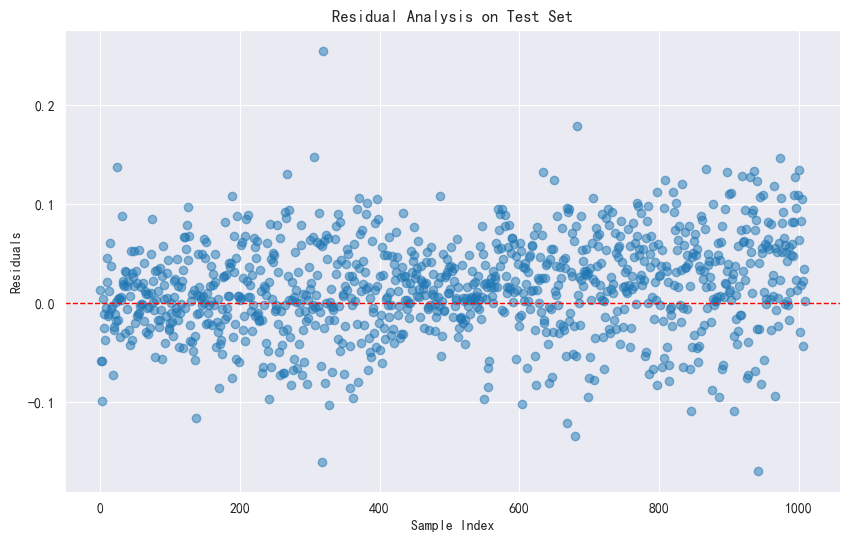

In [9]:
# 测试集预测
y_pred = model.predict(X_test)

# 反归一化
y_pred_rescaled = scaler.inverse_transform(y_pred)  # 反归一化预测值
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # 反归一化真实值

# 可视化残差分析
import matplotlib.pyplot as plt

residuals = y_test_rescaled - y_pred_rescaled  # 计算残差
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Residual Analysis on Test Set")
plt.xlabel("Sample Index")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

In [10]:
print(data['保值率'])

4070    0.124100
3431    0.124100
3402    0.124100
3433    0.153952
3418    0.156066
          ...   
4223    0.922545
319     0.897825
4342    0.809485
290     0.779283
710     0.756016
Name: 保值率, Length: 5073, dtype: float64


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

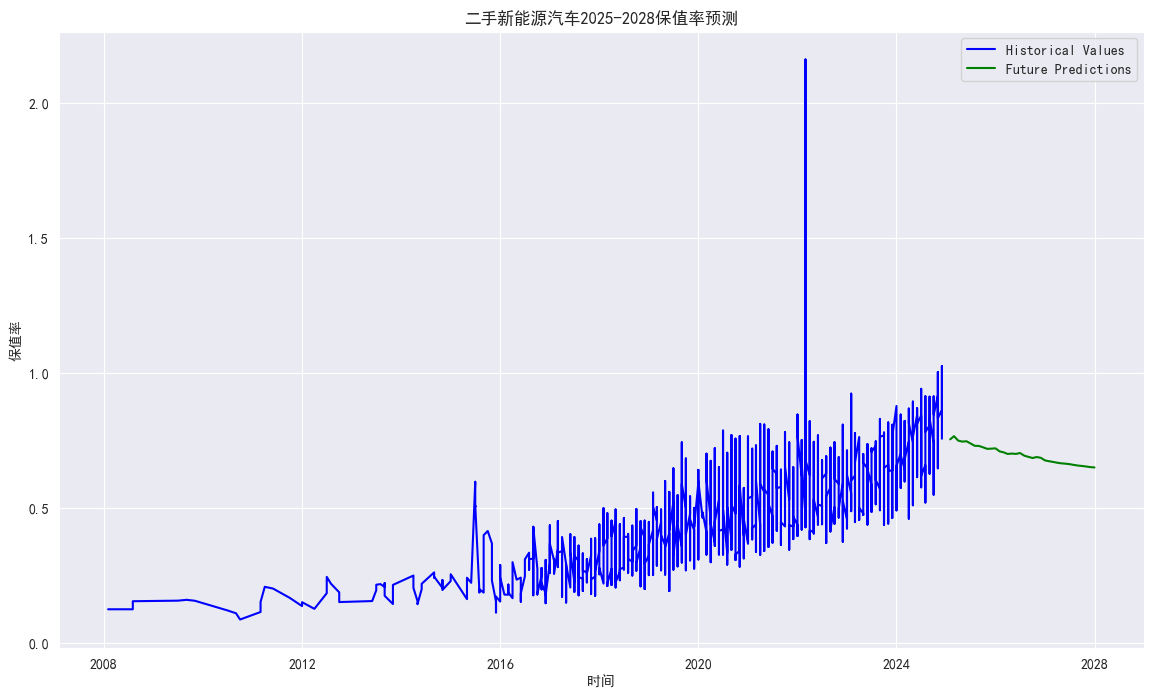

In [17]:
# 未来预测
future_steps = 36  # 未来36个月（3年）
last_sequence = X[-1]  # 从最后一个序列开始预测
future_predictions = []

for _ in range(future_steps):
    next_pred = model.predict(last_sequence[np.newaxis, :, :])  # 预测下一步
    future_predictions.append(next_pred[0, 0])
    last_sequence = np.append(last_sequence[1:], next_pred, axis=0)  # 更新序列

# 反归一化未来预测值
future_predictions_rescaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# 生成未来时间序列
last_date = data['上牌时间'].iloc[-1]  # 历史数据的最后日期
future_dates = pd.date_range(start=last_date, periods=future_steps + 1, freq='ME')[1:]

# 绘制未来预测图
plt.figure(figsize=(14, 8))

# 绘制历史数据
plt.plot(data['上牌时间'], data['保值率'], label="Historical Values", color='blue')

# 绘制未来预测数据
plt.plot(future_dates, future_predictions_rescaled, label="Future Predictions", color='green')

# 图形配置
plt.title("二手新能源汽车2025-2028保值率预测")
plt.xlabel("时间")
plt.ylabel("保值率")
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

C:\Users\13354\AppData\Local\Temp\ipykernel_14440\3050145672.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


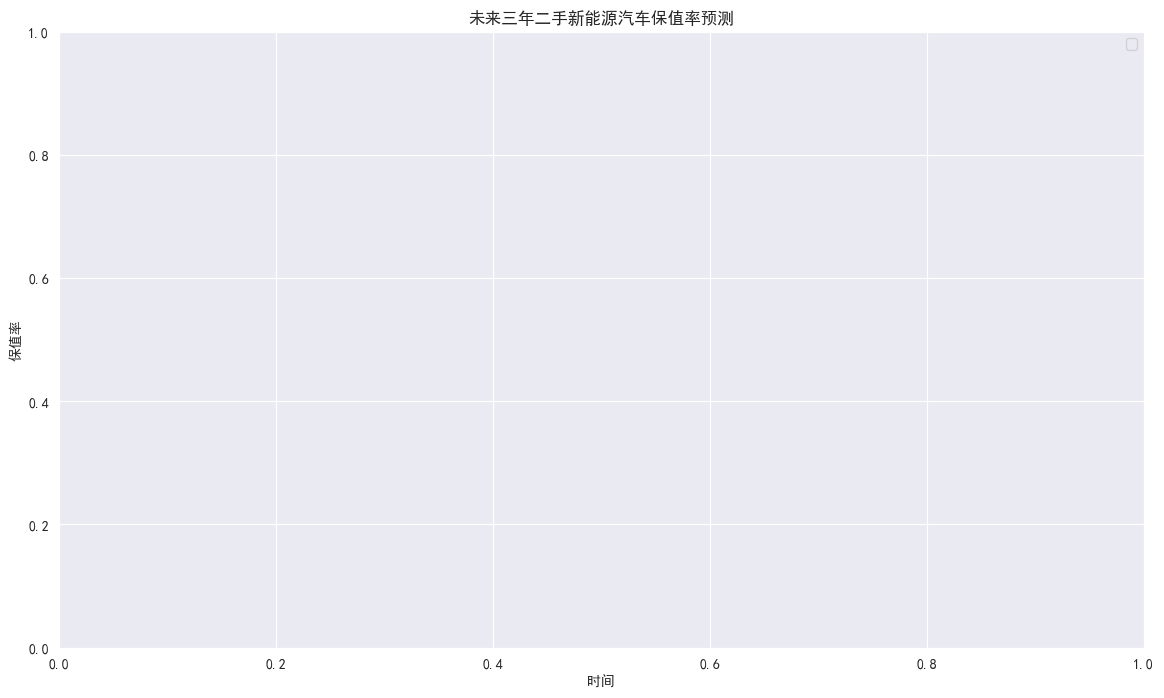

In [13]:
# 未来预测
future_steps = 36  # 未来36个月（3年）
last_sequence = X[-1]  # 从最后一个序列开始预测
future_predictions = []

for _ in range(future_steps):
    next_pred = model.predict(last_sequence[np.newaxis, :, :])  # 预测下一步
    future_predictions.append(next_pred[0, 0])
    last_sequence = np.append(last_sequence[1:], next_pred, axis=0)  # 更新序列

# 反归一化未来预测值
future_predictions_rescaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# 生成未来时间序列
last_date = data['上牌时间'].iloc[-1]  # 历史数据的最后日期
future_dates = pd.date_range(start=last_date, periods=future_steps + 1, freq='ME')[1:]

# 绘制未来预测图
plt.figure(figsize=(14, 8))
# 图形配置
plt.title("未来三年二手新能源汽车保值率预测")
plt.xlabel("时间")
plt.ylabel("保值率")
plt.legend()
plt.grid(True)
plt.show()
